# Прогнозирование оттока клиентов

### Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import axes

# SKLEARN

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

## Постановка задачи

Необходимо построить модель, прогнозирующую уход клиента из банка, с показателем F1-меры, не менее 0.59.
В качестве обучающих данных у нас имеются исторические данные о поведении клиентов и расторжении договоров с банком.

Перед нами задача классификации (не регрессии).

# 1. Подготовка данных

### Первичный анализ данных

Откроем файл с данными, посмотрим что у нас есть в наличии и определимся с дальнейшими шагами.

In [2]:
clients_data = pd.read_csv('/datasets/Churn.csv')
clients_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
clients_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


В столбце "Tenure" есть пропуски, почти 9% от общего объема данных. Удалять их не вариант, подумаем, что можно с этим сделать. Во-первых, отсутствие значений может соответствовать пропускам в форме сбора данных, заполняемой клиентом. Для уточнения этой версии, нам необходимо узнать, есть ли в столбце нулевые значения вообще. Если есть, то причина возникновения пропусков, скорее всего, иная. Проверим эту гипотезу.

Тип данных в столбцах "Tenure", "Balance", "EstimatedSalary" может быть заменен на целочисленный без потери качества данных и точности дальнейших расчетов. 

Интерес представляет столбец "Gender". Если это "продвинутый банк", гендеров там больше 2. Если "не очень продвинутый" - то 2. В любом случае, данный столбец имеет смысл "сходу" перекодировать в целочисленный вид.

Не совсем ясно, как столбцы "CustomerId" и "Surname" помогут нам при разработке модели. Эти данные необходимы в банковском деле, однако в нашей деятельности смысла от них нет и не предвидится. Удалим.

Столбец "RowNumber" дублирует индекс со смещением на 1. Тоже не нужен. Удаляем.

### Предобработка данных

Проверим, есть ли в столбце "Tenure" нулевые значения.

In [4]:
clients_data['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

Нулевые значения есть. Поэтому гипотеза "пропуски = отсутствие недвижимости" не может быть подтверждена (помним, что гипотеза может быть только непротиворечивой, но никак не подтвержденной). Вариант замены на нули не подходит.


Число объектов недвижимости - дискретные данные. Поскольку у нас нет возможности уточнить у источника данных причины возникновения пропусков, а также их точные значения, заполним пропуски медианным значением столбца "Tenure". Сделаем это и перейдем к изменению типов данных в столбцах "Tenure", "Balance", "EstimatedSalary".

In [5]:
clients_data['Tenure'] = clients_data['Tenure'].fillna(clients_data['Tenure'].median()).astype('int')
clients_data['Balance'] = clients_data['Balance'].astype('int')
clients_data['EstimatedSalary'] = clients_data['EstimatedSalary'].astype('int')
clients_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0,1,1,1,101348,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807,1,0,1,112542,0
2,3,15619304,Onio,502,France,Female,42,8,159660,3,1,0,113931,1
3,4,15701354,Boni,699,France,Female,39,1,0,2,0,0,93826,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510,1,1,1,79084,0


Посмотрим, какие значения есть в столбце "Gender". 

In [6]:
clients_data['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

Гендеров всего 2, ничего придумывать не нужно. Перекодированием займемся в следующем подпункте.

Переходим к удалению означенных ранее столбцов и смотрим на подготовленные данные ещё раз.

In [7]:
clients_data_clean = clients_data.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)
clients_data_clean.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0,1,1,1,101348,1
1,608,Spain,Female,41,1,83807,1,0,1,112542,0
2,502,France,Female,42,8,159660,3,1,0,113931,1
3,699,France,Female,39,1,0,2,0,0,93826,0
4,850,Spain,Female,43,2,125510,1,1,1,79084,0


Также оценим распределение значений целевого признака (столбец "Exited") для понимания необходимости перебалансировки обучающего датасета.

In [8]:
clients_data_clean['Exited'].value_counts(normalize = True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Значений "ушёл" больше чем значений "Не ушёл" почти в 4 раза - перебалансировке БЫТЬ. Но не сейчас. 

Сейчас нам необходимо разобраться с категориальными признаками - географией объекта (клиента) и гендерной принадлежностью. 

### Подготовка признаков

Воспользуемся методом прямого кодирования для преобразования категориальных переменных в числовые. Для устранения "ловушки", первый столбец удаляем.

In [9]:
exit_data_ohe = pd.get_dummies(clients_data_clean, drop_first = True)
exit_data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0,1,1,1,101348,1,0,0,0
1,608,41,1,83807,1,0,1,112542,0,0,1,0
2,502,42,8,159660,3,1,0,113931,1,0,0,0
3,699,39,1,0,2,0,0,93826,0,0,0,0
4,850,43,2,125510,1,1,1,79084,0,0,1,0


Вытаскиваем из датасета столбец с целевым признаком и, в связи с сильным различием между диапазоном варьирования и предельными значениями исходных признаков (например, возраста и ожидаемой зарплаты), переходим к стандартизации.

In [10]:
exit_features = exit_data_ohe.drop(['Exited'], axis = 1)
exit_target = exit_data_ohe['Exited']
exit_features.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0,1,1,1,101348,0,0,0
1,608,41,1,83807,1,0,1,112542,0,1,0
2,502,42,8,159660,3,1,0,113931,0,0,0
3,699,39,1,0,2,0,0,93826,0,0,0
4,850,43,2,125510,1,1,1,79084,0,1,0


In [11]:
exit_target.head(10)

0    1
1    0
2    1
3    0
4    0
5    1
6    0
7    1
8    0
9    0
Name: Exited, dtype: int64

### Стандартизация признаков

Как я отмечал ранее, у нас имеются признаки, существенно различающиеся в диапазонах и значениях варьирования. Их необходимо привести к единому масштабу. Под "масштабатор" подпадают столбцы "CreditScore", "Age", "Tenure", "Balance", "NumOfProducts" и "EstimatedSalary". 


In [12]:
clmns_to_scale = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(exit_features[clmns_to_scale])

exit_features[clmns_to_scale] = scaler.transform(exit_features[clmns_to_scale])
exit_features.head(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,-0.326221,0.293517,-1.086246,-1.225847,-0.911583,1,1,0.021880,0,0,0
1,-0.440036,0.198164,-1.448581,0.117342,-0.911583,0,1,0.216532,0,1,0
2,-1.536794,0.293517,1.087768,1.333050,2.527057,1,0,0.240686,0,0,0
3,0.501521,0.007457,-1.448581,-1.225847,0.807737,0,0,-0.108920,0,0,0
4,2.063884,0.388871,-1.086246,0.785723,-0.911583,1,1,-0.365269,0,1,0
5,-0.057205,0.484225,1.087768,0.597323,0.807737,1,0,0.863647,0,1,1
6,1.774174,1.056346,0.725432,-1.225847,0.807737,1,1,-1.565493,0,0,1
7,-2.840488,-0.946079,-0.361575,0.618014,4.246377,1,0,0.334847,1,0,0
8,-1.547141,0.484225,-0.361575,1.050828,0.807737,0,1,-0.437329,0,0,1
9,0.346319,-1.136786,-1.086246,0.931458,-0.911583,1,1,-0.493235,0,0,1


Пропуски обработаны, типы данных изменены, категориальные признаки перекодированы, количественные признаки масштабированы. Осталось нарезать полученные датасеты на обучающую, валидационную и тестовую в соотношении 70 : 15 : 15. Почему именно такое соотношение? 80-10-10 выглядит слишком перекошенным в сторону обучающей выборки - проверка модели на валидационной и тестовой выборках могут быть некорректными в связи с нехваткой соответствующих (валидационных и тестовых) данных.

In [13]:
features_train, features_tv, target_train, target_tv = train_test_split(
    exit_features, exit_target, test_size=0.3, random_state=11111)
print(features_train.shape)
print(features_tv.shape)
print(target_train.shape)
print(target_tv.shape)

(7000, 11)
(3000, 11)
(7000,)
(3000,)


In [14]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_tv, target_tv, test_size=0.5, random_state=11111)
print(features_valid.shape)
print(features_test.shape)
print(target_valid.shape)
print(target_test.shape)

(1500, 11)
(1500, 11)
(1500,)
(1500,)


Нарезано. Переходим к исследованию задачи без учета дисбаланса классов - вне зависимости от "распределения" целевого признака (а мы помним, у нас соотношение Positive : Negative составило 20 : 80).

# 2. Исследование моделей

Тестовые данные откладываем в сторону, будем работать с обучающей и валидационной выборками. На первой обучим модели, на второй подберем гиперпараметры моделей.

Начнем с "самого простого" - модели логистической регрессии.

### Логистическая регрессия

In [15]:
model_logreg = LogisticRegression(random_state = 11111, solver = 'liblinear')
model_logreg.fit(features_train, target_train)

models_list_test = []
models_list_test.append("model_logreg")

Показатели качества модели в данном проекте - значения F1-меры и AUC-ROC. Проверим значения объявленных показателей полученной модели на валидационной выборке. 

In [16]:
predict_logreg = model_logreg.predict(features_valid)
f1_score_logreg = f1_score(target_valid, predict_logreg)
print("Значение f1_score для модели логистической регресии равно:", f1_score_logreg)

Значение f1_score для модели логистической регресии равно: 0.3296703296703297


Уже сейчас очевидно, что значение F1-меры модели логистической регрессии не достигает и половины целевого значения рассматриваемого параметра. Конечно, мы можем "забить" на данную модель и перейти к деревьям (в различном количестве). Однако, для понимания поведения моделей при изменении баланса классов, я найду значений AUC-ROC для данной модели и помещу их в специальную таблицу, в которую буду собирать значения показателей качества различных моделей с различной балансировкой классов.

В таблице будет 6 столбцов - название модели (Лог-рег, дерево, лес), максимальная глубина (у лог-рег тут будет пропуска), число деревьев (у отдельного дерева и лог-рег здесь будут пропуски), способ балансировки классов (нет, up, down) и 2 столбца с показателями качества - F1 и AUC-ROC.

Создадим таблицу, рассчитаем AUC-ROC для логистической регрессии и добавим в нее первую строчку со значениями. 

In [17]:
comparison_columns = ["model_type", "max_depth", "n_estimators", "balance_type", "f1_score", "auc_roc_score"]
models_comparison = pd.DataFrame(data = None, columns = comparison_columns)

In [18]:
probabilities_valid_logreg = model_logreg.predict_proba(features_valid)
probabilities_one_valid_logreg = probabilities_valid_logreg[:, 1]
auc_roc_logreg = roc_auc_score(target_valid, probabilities_one_valid_logreg)

In [19]:
models_comparison.loc[0, "model_type"] = "Logistic regression"
models_comparison.loc[0, "f1_score"] = f1_score_logreg
models_comparison.loc[0, "auc_roc_score"] = auc_roc_logreg
models_comparison

,model_type,max_depth,n_estimators,balance_type,f1_score,auc_roc_score
0,Logistic regression,NaN,NaN,NaN,0.32967,0.756852


Первая строка заполнена, переходим к другим моделям.

### Решающее древо

Обучение решающего древа произведем параллельно с подбором гиперпараметров. Сначала "проскачем" по значениям глубины решающего древа с большим шагом, а затем подберем значение решающего древа с максимальным значениями показателя F1-меры. Чтобы не использовать циклы в теле проекта, "засунем" их внутрь функции и будем вызывать по мере необходимости.

In [20]:
def dectree_hyper_finder(min_depth, max_depth, step):
    f1_score_max = 0
    auc_roc_max = 0
    depth_target = 0
    for depth in range(min_depth, max_depth+1, step):
        
#         обучаем
        model_dectree = DecisionTreeClassifier(max_depth = depth, random_state = 11111)
        model_dectree.fit(features_train, target_train)
        
#         ищем глубину с максимальным значением f1
        predict_dectree = model_dectree.predict(features_valid)
        f1_score_dectree = f1_score(target_valid, predict_dectree)
        if f1_score_dectree > f1_score_max:
            f1_score_max = f1_score_dectree
            depth_target = depth
    return f1_score_max, depth_target
dectree_hyper_finder(2, 52, 5)    

(0.5207547169811321, 7)

Получили диапазон, который необходимо перебрать более тщательно - в окрестностях полученного значения + шаг перебора в обе стороны. В нашем случае это диапазон глубины решающего дерева (2 - 12). 

In [21]:
dectree_hyper_finder(2, 12, 1)

(0.535773710482529, 10)

Наилучшее значение F1 меры получено для решающего древа глубиной 10. Обучим модель с соответствующим значением гиперпараметров, рассчитаем для него целевые значения F1 меры и AUC-ROC и занесем их в таблицу. Для снижения "трудоемкости", напишем "рассчетно-вносящую" функцию. 

In [22]:
model_dectree_best = DecisionTreeClassifier(max_depth = 10, random_state = 11111)
model_dectree_best.fit(features_train, target_train)

models_list_test.append("model_dectree_best")

def table_filler(model_name, table_model_name, row_number):
    
#     считаем f1-меру
    f1_score_model = f1_score(target_valid, model_name.predict(features_valid))

#     считаем значение AUC-ROC
    probabilities_valid = model_name.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc_model = roc_auc_score(target_valid, probabilities_one_valid)
    
#     складываем в таблицу вместе с названием
    models_comparison.loc[row_number, "model_type"] = table_model_name
    models_comparison.loc[row_number, "f1_score"] = f1_score_model
    models_comparison.loc[row_number, "auc_roc_score"] = auc_roc_model
    return models_comparison

table_filler(model_dectree_best, "Decision Tree", 1)

,model_type,max_depth,n_estimators,balance_type,f1_score,auc_roc_score
0,Logistic regression,NaN,NaN,NaN,0.32967,0.756852
1,Decision Tree,NaN,NaN,NaN,0.535774,0.752397


Добавим в таблицу имеющийся гиперпараметр - глубину = 10. 

In [23]:
models_comparison.loc[1, "max_depth"] = 10
models_comparison

,model_type,max_depth,n_estimators,balance_type,f1_score,auc_roc_score
0,Logistic regression,NaN,NaN,NaN,0.32967,0.756852
1,Decision Tree,10,NaN,NaN,0.535774,0.752397


Целевое значение f1-score (0,59) не получено. Перейдем к случайному лесу.

### Случайный лес

По аналогии с решающим древом нам необходимо подобрать гиперпараметры случайного леса. Их 2 - максимальная глубина деревьев и количество параллельно решающих деревьев.

> Поскольку я не до конца (на момент написания данных строк) понимаю, как работает случайный лес в вопросе подбора гиперпараметров - сначала подбираем число "решателей", затем для них находим "наилучшую глубину" или сначала подбираем глубину (можем воспользоваться уже найденной для решающего древа) и потом идем в сторону "наилучшего" числа "решателей" или нужно делать прогон сразу по 2 параметрам (но это изначально выглядит глупо с точки зрения затрат времени). 

> Потому вопрос - как это работает? Можете дать какие-то рекомендации по подбору гиперпараметров случайного леса?

Поскольку гипотез относительно того, как это работает у меня 3 (описаны выше), проверим на работоспособность каждую из них и попробуем "к чему-нибудь" прийти. Начнем с подбора числа "решателей" для "наилучшей" глубины решающего древа, рассчитанной ранее и равной 10. По аналогии напишем функцию определения числа решателей для модели случайного леса с наибольшим значением f1-меры.

In [24]:
def rndforest_est_finder(min_est, max_est, step):
    f1_score_max = 0
    auc_roc_max = 0
    est_target = 0
    for est in range(min_est, max_est+1, step):
        
#         обучаем
        model_rndforest = RandomForestClassifier(max_depth = 10, n_estimators = est, random_state = 11111)
        model_rndforest.fit(features_train, target_train)
        
#         ищем число "решателей" с максимальным значением f1
        predict_rndforest = model_rndforest.predict(features_valid)
        f1_score_rndforest = f1_score(target_valid, predict_rndforest)
        if f1_score_rndforest > f1_score_max:
            f1_score_max = f1_score_rndforest
            est_target = est
    return f1_score_max, est_target

rndforest_est_finder(2, 22, 5)

(0.5402298850574713, 22)

Проверка диапазона от 2 до 22 "решателей" показала, что:

1. Нам нужно двигаться дальше
2. Целевое значение F1-score не достигнуто
3. Истина где-то рядом

Проверяем дальше.

In [25]:
rndforest_est_finder(22, 52, 5)

(0.5598455598455597, 42)

Искомый диапазон "раскопок" получен, однако, на мой неопытный взгляд, данный подход (с "лучшей" глубиной), скорее всего, не верен. Т.е. если для Решающего древа максимальная глубина = 10 - наилучшая, то это не всегда работает для случайного леса. 

> Что решающему древу хорошо, то случайному лесу - снижение целевых значений качества!

В любом случае, доведем наше исследование до конца и посмотрим на итоговый результат для глубины деревьев = 10.

In [26]:
%%time
rndforest_est_finder(37, 47, 1)

CPU times: user 4.13 s, sys: 0 ns, total: 4.13 s
Wall time: 4.24 s


(0.5615384615384615, 43)

Итак, случайный лес из 43 решающих деревьев глубиной 10 позволил получить показатель f1-меры равный 0.5615. Недостаточно. Переходим ко второй гипотезе - подбору числа "решателей", с последующим подбором глубины этих самых "решателей". Нам также потребуется функция (в немного измененном виде).

Убираем из функции число решающих деревьев (в качестве варьируемого параметра) и запускаем подбор числа "решателей".

In [27]:
def rndforest_nodepth_est_finder(min_est, max_est, step):
    f1_score_max = 0
    auc_roc_max = 0
    est_target = 0
    for est in range(min_est, max_est+1, step):
        
#         обучаем
        model_rndforest = RandomForestClassifier(n_estimators = est, random_state = 11111)
        model_rndforest.fit(features_train, target_train)
        
#         ищем число "решателей" с максимальным значением f1
        predict_rndforest = model_rndforest.predict(features_valid)
        f1_score_rndforest = f1_score(target_valid, predict_rndforest)
        if f1_score_rndforest > f1_score_max:
            f1_score_max = f1_score_rndforest
            est_target = est
    return f1_score_max, est_target

rndforest_nodepth_est_finder(2, 22, 5)

(0.5698729582577132, 17)

Как говорит один человек из интернета - "Ничего не понятно. Но очень интересно!"
Всего 17 деревьев, а показатель f1-score уже выше. 
Проверим окрестности, выберем "лучшего" и запустим ту же самую историю с точки зрения подбора "наилучшей" глубины решающих деревьев.

In [28]:
%%time
rndforest_nodepth_est_finder(12, 22, 1)

CPU times: user 2.11 s, sys: 4 ms, total: 2.11 s
Wall time: 2.12 s


(0.5719489981785063, 15)

15 решающих деревьев, максимальная глубина неясна. "Прогоним" полученное наилучшее число "Решателей" через подбор глубины дерева.

In [29]:
def rndforest_depth_finder(min_depth, max_depth, step):
    f1_score_max = 0
    auc_roc_max = 0
    depth_target = 0
    for depth in range(min_depth, max_depth+1, step):
        
#         обучаем
        model_rndforest = RandomForestClassifier(max_depth = depth, n_estimators = 15, random_state = 11111)
        model_rndforest.fit(features_train, target_train)
        
#         ищем глубину с максимальным значением f1
        predict_rndforest = model_rndforest.predict(features_valid)
        f1_score_rndforest = f1_score(target_valid, predict_rndforest)
        if f1_score_rndforest > f1_score_max:
            f1_score_max = f1_score_rndforest
            depth_target = depth
    return f1_score_max, depth_target

rndforest_depth_finder(2, 22, 5)

(0.5641025641025641, 22)

Глубины 22 недостаточно. Погружаемся!

In [30]:
rndforest_depth_finder(22, 52, 5)

(0.5719489981785063, 27)

Окрестности получены, исследуем.

In [31]:
%%time
rndforest_depth_finder(22, 32, 1)

CPU times: user 1.88 s, sys: 0 ns, total: 1.88 s
Wall time: 1.89 s


(0.5781818181818182, 25)

Итак, максимальное значение f1-score, равное 0.5781, получено для случайного леса из 15 деревьев максимальной глубины 25. Лучше, чем было при проверке первой гипотезы. Проверим 3 гипотезу - будем определять и число решающих деревьев и их максимальную глубину  ОДНОВРЕМЕННО! (Цикл в цикле, ВАУ!). Воспользуемся ещё 1 функцией.

In [32]:
%%time
def rndforest_depth_est_finder(min_est, max_est, step_est, min_depth, max_depth, step_depth):
    f1_score_max = 0
    auc_roc_max = 0
    depth_target = 0
    est_target = 0
    for est in range(min_est, max_est+1, step_est):
        for depth in range(min_depth, max_depth+1, step_depth):
            
#             Обучаем
            model_rndforest = RandomForestClassifier(max_depth = depth, n_estimators = est, random_state = 11111)
            model_rndforest.fit(features_train, target_train)
            
#             Ищем лучшие глубину и число "решателей"
            predict_rndforest = model_rndforest.predict(features_valid)
            f1_score_rndforest = f1_score(target_valid, predict_rndforest)
            if f1_score_rndforest > f1_score_max:
                f1_score_max = f1_score_rndforest
                depth_target = depth
                est_target = est
                
    return f1_score_max, est_target, depth_target

rndforest_depth_est_finder(2, 32, 5, 2, 52, 5)

CPU times: user 13.3 s, sys: 20 ms, total: 13.3 s
Wall time: 13.3 s


(0.5698729582577132, 17, 27)

Второе значение - число решателей, третье - глубина. 

Диапазон выглядит очень похожим на то, что мы получили ранее. Проверяем дальше.

In [33]:
%%time
rndforest_depth_est_finder(12, 22, 1, 22, 32, 1)

CPU times: user 23.2 s, sys: 32 ms, total: 23.2 s
Wall time: 23.3 s


(0.5781818181818182, 15, 25)

И на нашей улице перевернулся грузовик с арбузами. 
Результаты, полученные 2 и 3 способами идентичны. При этом, по временным затратам, очевидным лидером является способ номер 2 - с подбором сначала числа "решателей", а только потом глубины этих самых "решателей".

Поместим данные о полученной модели в таблицу для сравнения.

In [34]:
model_rndforest_best = RandomForestClassifier(max_depth = 25, n_estimators = 15, random_state = 11111)
model_rndforest_best.fit(features_train, target_train)

models_list_test.append("model_rndforest_best")

models_comparison.loc[2, "max_depth"] = 25
models_comparison.loc[2, "n_estimators"] = 15

table_filler(model_rndforest_best, "Random Forest", 2)

,model_type,max_depth,n_estimators,balance_type,f1_score,auc_roc_score
0,Logistic regression,NaN,NaN,NaN,0.32967,0.756852
1,Decision Tree,10,NaN,NaN,0.535774,0.752397
2,Random Forest,25,15,NaN,0.578182,0.793588


### Выводы по разделу 2 "Исследование задачи"

1. Наибольшее значение F1-меры получено для модели случайного леса с 15 "решателями" максимальной глубины равной 25. Наименьшее - для модели логистической регрессии. 
2. Различия в значении параметра AUC-ROC для исследованных типов моделей существенно ниже, чем в случае F1-меры. "Пальма первенства" - по-прежнему у случайного леса.
3. Целевое значение показателя качества модели (F1-меры), равное 0.59 не достигнуто. "Докрутка" модели будет осуществлена посредством перебалансировки классов.

# 3. Борьба с дисбалансом



Как мы помним из раздела "Подготовка данных", соотношение числа значений целевого признака составляет 4 к 1. 
Мне известно 3 способа перебалансировки классов - с помощью стандартного "балансира" (class_weight = "balanced"), апсамплинг и даунсамплинг. Воспользуемся стандартным методом изменения веса класса и посмотрим, как это повлияет на значение целевого показателя.

### 3.1 Class_weight = "balanced"

In [35]:
model_logreg_balanced = LogisticRegression(random_state = 11111, class_weight = "balanced", solver = 'liblinear')
model_logreg_balanced.fit(features_train, target_train)
predict_logreg_balanced = model_logreg_balanced.predict(features_valid)
f1_score_logreg_balanced = f1_score(target_valid, predict_logreg_balanced)
print("Значение f1_score для модели логистической регресии со сбалансированными классами равно:",
      f1_score_logreg_balanced)

models_list_test.append("model_logreg_balanced")

Значение f1_score для модели логистической регресии со сбалансированными классами равно: 0.49336283185840707


Значение f1-меры для модели со сбалансированными классами выросло почти в 1.5 раза! Прогресс, но для "ответа" на наш вопрос данного значения явно недостаточно. Занесем полученные данные в таблицу и продолжим движение в направлении "сбалансированного" решающего древа.

In [36]:
models_comparison.loc[3, "model_type"] = "Logistic regression"
models_comparison.loc[3, "balance_type"] = "class_weight"
models_comparison.loc[3, "f1_score"] = f1_score_logreg_balanced

probabilities_valid_logreg_balanced = model_logreg_balanced.predict_proba(features_valid)
probabilities_one_valid_logreg_balanced = probabilities_valid_logreg_balanced[:, 1]
auc_roc_logreg_balanced = roc_auc_score(target_valid, probabilities_one_valid_logreg_balanced)

models_comparison.loc[3, "auc_roc_score"] = auc_roc_logreg_balanced
models_comparison

,model_type,max_depth,n_estimators,balance_type,f1_score,auc_roc_score
0,Logistic regression,NaN,NaN,NaN,0.32967,0.756852
1,Decision Tree,10,NaN,NaN,0.535774,0.752397
2,Random Forest,25,15,NaN,0.578182,0.793588
3,Logistic regression,NaN,NaN,class_weight,0.493363,0.75879


При этом данный тип балансировки практически не повлиял на значение показателя AUC-ROC.

И снова я ставлю перед собой важный вопрос - нужно ли подбирать значения гиперпараметров "заново" при перебалансировке весов целевого признака? Гипотез 2. 1-я - нужно. 2-я - не нужно. Начнем с проверки гипотезы №1. Решающее дерево, я выбираю тебя!

### Решающее древо

In [37]:
def dectree_balanced_hyper_finder(min_depth, max_depth, step):
    f1_score_max = 0
    auc_roc_max = 0
    depth_target = 0
    for depth in range(min_depth, max_depth+1, step):
        
#         обучаем
        model_dectree = DecisionTreeClassifier(max_depth = depth, class_weight = "balanced", random_state = 11111)
        model_dectree.fit(features_train, target_train)
        
#         ищем глубину с максимальным значением f1
        predict_dectree = model_dectree.predict(features_valid)
        f1_score_dectree = f1_score(target_valid, predict_dectree)
        if f1_score_dectree > f1_score_max:
            f1_score_max = f1_score_dectree
            depth_target = depth
    return f1_score_max, depth_target

dectree_balanced_hyper_finder(2, 52, 5)    

(0.5306122448979591, 7)

In [38]:
dectree_balanced_hyper_finder(2, 12, 1)    

(0.5454545454545455, 10)

Глубина древа та же, что и в случае несбалансированных классов. На решающем древе гипотеза о "Необходимости переподбора гиперпараметров" не подтвердилась. Занесем полученные значения в таблицу и провернем ту же самую историю со случайным лесом. 

In [39]:
model_dectree_balanced_best = DecisionTreeClassifier(max_depth = 10,
                                                     class_weight = "balanced", random_state = 11111)
model_dectree_balanced_best.fit(features_train, target_train)

models_list_test.append("model_dectree_balanced_best")

In [40]:
models_comparison.loc[4, "max_depth"] = 10
models_comparison.loc[4, "balance_type"] = "class_weight"

table_filler(model_dectree_balanced_best, "Decision Tree", 4)

,model_type,max_depth,n_estimators,balance_type,f1_score,auc_roc_score
0,Logistic regression,NaN,NaN,NaN,0.32967,0.756852
1,Decision Tree,10,NaN,NaN,0.535774,0.752397
2,Random Forest,25,15,NaN,0.578182,0.793588
3,Logistic regression,NaN,NaN,class_weight,0.493363,0.75879
4,Decision Tree,10,NaN,class_weight,0.545455,0.730038


### Случайный лес

Модель другая, логика та же. Проверяем.

In [41]:
def rndforest_balanced_nodepth_est_finder(min_est, max_est, step):
    f1_score_max = 0
    auc_roc_max = 0
    est_target = 0
    for est in range(min_est, max_est+1, step):
        
#         обучаем
        model_rndforest = RandomForestClassifier(n_estimators = est,
                                                 class_weight = "balanced", random_state = 11111)
        model_rndforest.fit(features_train, target_train)
        
#         ищем число "решателей" с максимальным значением f1
        predict_rndforest = model_rndforest.predict(features_valid)
        f1_score_rndforest = f1_score(target_valid, predict_rndforest)
        if f1_score_rndforest > f1_score_max:
            f1_score_max = f1_score_rndforest
            est_target = est
    return f1_score_max, est_target

rndforest_balanced_nodepth_est_finder(2, 22, 5)

(0.5325884543761639, 17)

In [42]:
rndforest_balanced_nodepth_est_finder(12, 22, 1)

(0.5325884543761639, 17)

АГА! Что-то новенькое. 17 "решателей" против 15 в предшествующем примере. Проверяем глубину.

In [43]:
def rndforest_balanced_depth_finder(min_depth, max_depth, step):
    f1_score_max = 0
    auc_roc_max = 0
    depth_target = 0
    for depth in range(min_depth, max_depth+1, step):
        
#         обучаем
        model_rndforest = RandomForestClassifier(max_depth = depth, n_estimators = 17,
                                                 class_weight = "balanced", random_state = 11111)
        model_rndforest.fit(features_train, target_train)
        
#         ищем глубину с максимальным значением f1
        predict_rndforest = model_rndforest.predict(features_valid)
        f1_score_rndforest = f1_score(target_valid, predict_rndforest)
        if f1_score_rndforest > f1_score_max:
            f1_score_max = f1_score_rndforest
            depth_target = depth
    return f1_score_max, depth_target

rndforest_balanced_depth_finder(2, 52, 5)

(0.601078167115903, 7)

In [44]:
rndforest_balanced_depth_finder(2,12,1)

(0.601078167115903, 7)

Глубина также "существенно" ниже - 7 против 25.
Плюс, мы достигли целевого значения f1-меры = 0.59.
Продолжаем наблюдения. Результаты - в таблицу.

In [45]:
model_rndforest_balanced_best = RandomForestClassifier(max_depth = 7, n_estimators = 17,
                                                 class_weight = "balanced", random_state = 11111)
model_rndforest_balanced_best.fit(features_train, target_train)

models_list_test.append("model_rndforest_balanced_best")

models_comparison.loc[5, "max_depth"] = 7
models_comparison.loc[5, "n_estimators"] = 17
models_comparison.loc[5, "balance_type"] = "class_weight"

table_filler(model_rndforest_balanced_best, "Random Forest", 5)

,model_type,max_depth,n_estimators,balance_type,f1_score,auc_roc_score
0,Logistic regression,NaN,NaN,NaN,0.32967,0.756852
1,Decision Tree,10,NaN,NaN,0.535774,0.752397
2,Random Forest,25,15,NaN,0.578182,0.793588
3,Logistic regression,NaN,NaN,class_weight,0.493363,0.75879
4,Decision Tree,10,NaN,class_weight,0.545455,0.730038
5,Random Forest,7,17,class_weight,0.601078,0.830275


Проверим другие способы разрешения проблемы несбалансированных классов. 

### 3.2 Downsampling

Посмотрим на соотношение значений целевого признака в обучающей выборке.

In [46]:
target_train.value_counts(normalize = True)

0    0.798714
1    0.201286
Name: Exited, dtype: float64

Отрицательных значений примерно в 4 раза больше, чем положительных. Стало быть, для восстановления баланса классов "ВНИЗ", нам необходимо оставить 25% объектов с отрицательным значением целевого признака.

Обучающая выборка содержится в переменных features_train и target_train.

In [47]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(features_downsampled.shape)
print(target_downsampled.shape)

(2807, 11)
(2807,)


In [48]:
target_downsampled.value_counts()

1    1409
0    1398
Name: Exited, dtype: int64

Обучим модели на новой выборке и проверим полученные результаты на валидационной выборке.

In [49]:
model_logreg_downsampled = LogisticRegression(random_state = 11111, solver = 'liblinear')
model_logreg_downsampled.fit(features_downsampled, target_downsampled)

models_list_test.append("model_logreg_downsampled")

predict_logreg_downsampled = model_logreg_downsampled.predict(features_valid)
f1_score_logreg_downsampled = f1_score(target_valid, predict_logreg_downsampled)
print("Значение f1_score для модели логистической регресии равно:", f1_score_logreg_downsampled)

Значение f1_score для модели логистической регресии равно: 0.5038335158817085


Ещё небольшой прирост значения f1-меры по сравнению со "стандратной" перебалансировкой классов. Рассчитаем значение AUC-ROC и внесем данные в таблицу.

In [50]:
probabilities_valid_logreg_downsampled = model_logreg_downsampled.predict_proba(features_valid)
probabilities_one_valid_logreg_downsampled = probabilities_valid_logreg_downsampled[:, 1]
auc_roc_logreg_downsampled = roc_auc_score(target_valid, probabilities_one_valid_logreg_downsampled)

In [51]:
models_comparison.loc[6, "model_type"] = "Logistic regression"
models_comparison.loc[6, "f1_score"] = f1_score_logreg_downsampled
models_comparison.loc[6, "balance_type"] = "Downsampling"
models_comparison.loc[6, "auc_roc_score"] = auc_roc_logreg_downsampled
models_comparison

,model_type,max_depth,n_estimators,balance_type,f1_score,auc_roc_score
0,Logistic regression,NaN,NaN,NaN,0.32967,0.756852
1,Decision Tree,10,NaN,NaN,0.535774,0.752397
2,Random Forest,25,15,NaN,0.578182,0.793588
3,Logistic regression,NaN,NaN,class_weight,0.493363,0.75879
4,Decision Tree,10,NaN,class_weight,0.545455,0.730038
5,Random Forest,7,17,class_weight,0.601078,0.830275
6,Logistic regression,NaN,NaN,Downsampling,0.503834,0.759156


Прирост показателя AUC-ROC в сравнении с предшествующими методиками балансировки незначителен. Переходим к решающему дереву.

### Решающее дерево

In [52]:
def dectree_depth_downsampled_finder(min_depth, max_depth, step):
    f1_score_max = 0
    auc_roc_max = 0
    depth_target = 0
    for depth in range(min_depth, max_depth+1, step):
        
#         обучаем
        model_dectree = DecisionTreeClassifier(max_depth = depth, random_state = 11111)
        model_dectree.fit(features_downsampled, target_downsampled)
        
#         ищем глубину с максимальным значением f1
        predict_dectree = model_dectree.predict(features_valid)
        f1_score_dectree = f1_score(target_valid, predict_dectree)
        if f1_score_dectree > f1_score_max:
            f1_score_max = f1_score_dectree
            depth_target = depth
    return f1_score_max, depth_target

dectree_depth_downsampled_finder(2,52,5)

(0.5435779816513762, 7)

In [53]:
dectree_depth_downsampled_finder(2,7,1)

(0.5685019206145966, 6)

Небольшой прирост значения F1-меры по сравнению с методикой "стандартной" балансировки. 

Внесем данные в таблицу и обратимся к случайному лесу.

In [54]:
model_dectree_downsampled_best = DecisionTreeClassifier(max_depth = 6, random_state = 11111)
model_dectree_downsampled_best.fit(features_downsampled, target_downsampled)

models_list_test.append("model_dectree_downsampled_best")

In [55]:
models_comparison.loc[7, "max_depth"] = 6
models_comparison.loc[7, "balance_type"] = "Downsampling"
table_filler(model_dectree_downsampled_best, "Decision Tree", 7)

,model_type,max_depth,n_estimators,balance_type,f1_score,auc_roc_score
0,Logistic regression,NaN,NaN,NaN,0.32967,0.756852
1,Decision Tree,10,NaN,NaN,0.535774,0.752397
2,Random Forest,25,15,NaN,0.578182,0.793588
3,Logistic regression,NaN,NaN,class_weight,0.493363,0.75879
4,Decision Tree,10,NaN,class_weight,0.545455,0.730038
5,Random Forest,7,17,class_weight,0.601078,0.830275
6,Logistic regression,NaN,NaN,Downsampling,0.503834,0.759156
7,Decision Tree,6,NaN,Downsampling,0.568502,0.803579


Несмотря на незначительное снижение показателя f1-меры, прирост AUC-ROC весьма и весьма значителен - почти на 10% (от 0.73 до 0.8).

### Случайный лес

In [56]:
def rndforest_nodepth_est_downsampled_finder(min_est, max_est, step):
    f1_score_max = 0
    auc_roc_max = 0
    est_target = 0
    for est in range(min_est, max_est+1, step):
        
#         обучаем
        model_rndforest = RandomForestClassifier(n_estimators = est, random_state = 11111)
        model_rndforest.fit(features_downsampled, target_downsampled)
        
#         ищем число "решателей" с максимальным значением f1
        predict_rndforest = model_rndforest.predict(features_valid)
        f1_score_rndforest = f1_score(target_valid, predict_rndforest)
        if f1_score_rndforest > f1_score_max:
            f1_score_max = f1_score_rndforest
            est_target = est
    return f1_score_max, est_target

rndforest_nodepth_est_downsampled_finder(2, 22, 5)

(0.5796019900497512, 22)

"Уперлись" в 22 дерева. Расширим границы.

In [57]:
rndforest_nodepth_est_downsampled_finder(22, 42, 5)

(0.5827160493827162, 32)

In [58]:
rndforest_nodepth_est_downsampled_finder(27, 37, 1)

(0.5834363411619282, 28)

Теперь глубина.

In [59]:
def rndforest_downsampled_depth_finder(min_depth, max_depth, step):
    f1_score_max = 0
    auc_roc_max = 0
    depth_target = 0
    for depth in range(min_depth, max_depth+1, step):
        
#         обучаем
        model_rndforest = RandomForestClassifier(max_depth = depth,
                                                 n_estimators = 28, random_state = 11111)
        model_rndforest.fit(features_downsampled, target_downsampled)
        
#         ищем глубину с максимальным значением f1
        predict_rndforest = model_rndforest.predict(features_valid)
        f1_score_rndforest = f1_score(target_valid, predict_rndforest)
        if f1_score_rndforest > f1_score_max:
            f1_score_max = f1_score_rndforest
            depth_target = depth
    return f1_score_max, depth_target

rndforest_downsampled_depth_finder(2, 52, 5)

(0.5939393939393939, 7)

In [60]:
rndforest_downsampled_depth_finder(2,12,1)

(0.5961070559610706, 9)

Максимальная глубина деревьев теперь равна 9. 

Заносим в таблицу и переходим к "повышающему" методу.

In [61]:
model_rndforest_downsampled_best = RandomForestClassifier(max_depth = 9, n_estimators = 28, random_state = 11111)
model_rndforest_downsampled_best.fit(features_downsampled, target_downsampled)

models_list_test.append("model_rndforest_downsampled_best")

In [62]:
models_comparison.loc[8, "max_depth"] = 9
models_comparison.loc[8, "n_estimators"] = 28

models_comparison.loc[8, "balance_type"] = "Downsampling"
table_filler(model_rndforest_downsampled_best, "Random Forest", 8)

,model_type,max_depth,n_estimators,balance_type,f1_score,auc_roc_score
0,Logistic regression,NaN,NaN,NaN,0.32967,0.756852
1,Decision Tree,10,NaN,NaN,0.535774,0.752397
2,Random Forest,25,15,NaN,0.578182,0.793588
3,Logistic regression,NaN,NaN,class_weight,0.493363,0.75879
4,Decision Tree,10,NaN,class_weight,0.545455,0.730038
5,Random Forest,7,17,class_weight,0.601078,0.830275
6,Logistic regression,NaN,NaN,Downsampling,0.503834,0.759156
7,Decision Tree,6,NaN,Downsampling,0.568502,0.803579
8,Random Forest,9,28,Downsampling,0.596107,0.832392


Снижение F1-меры по сравнению со стандартной балансировкой незначительно. Значение AUC-ROC слегка выше.

### 3.3 Upsampling

Теперь вместо уменьшения в 5 раз, нам необходимо 5 раз продублировать положительные объекты и перемешать их с отрицательными в соотношении "примерно" 1 к 1.

In [63]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
print(features_upsampled.shape)
print(target_upsampled.shape)

(11227, 11)
(11227,)


In [64]:
target_upsampled.value_counts()

1    5636
0    5591
Name: Exited, dtype: int64

Первая на очереди - модель логистической регрессии.

In [65]:
model_logreg_upsampled = LogisticRegression(random_state = 11111, solver = 'liblinear')
model_logreg_upsampled.fit(features_upsampled, target_upsampled)

models_list_test.append("model_logreg_upsampled")

predict_logreg_upsampled = model_logreg_upsampled.predict(features_valid)
f1_score_logreg_upsampled = f1_score(target_valid, predict_logreg_upsampled)

print("Значение f1_score для модели логистической регресии со сбалансированными классами равно:",
      f1_score_logreg_upsampled)

Значение f1_score для модели логистической регресии со сбалансированными классами равно: 0.49227373068432667


In [66]:
models_comparison.loc[9, "model_type"] = "Logistic regression"
models_comparison.loc[9, "balance_type"] = "Upsampling"
models_comparison.loc[9, "f1_score"] = f1_score_logreg_upsampled

probabilities_valid_logreg_upsampled = model_logreg_upsampled.predict_proba(features_valid)
probabilities_one_valid_logreg_upsampled = probabilities_valid_logreg_upsampled[:, 1]
auc_roc_logreg_upsampled = roc_auc_score(target_valid, probabilities_one_valid_logreg_upsampled)

models_comparison.loc[9, "auc_roc_score"] = auc_roc_logreg_upsampled
models_comparison

,model_type,max_depth,n_estimators,balance_type,f1_score,auc_roc_score
0,Logistic regression,NaN,NaN,NaN,0.32967,0.756852
1,Decision Tree,10,NaN,NaN,0.535774,0.752397
2,Random Forest,25,15,NaN,0.578182,0.793588
3,Logistic regression,NaN,NaN,class_weight,0.493363,0.75879
4,Decision Tree,10,NaN,class_weight,0.545455,0.730038
5,Random Forest,7,17,class_weight,0.601078,0.830275
6,Logistic regression,NaN,NaN,Downsampling,0.503834,0.759156
7,Decision Tree,6,NaN,Downsampling,0.568502,0.803579
8,Random Forest,9,28,Downsampling,0.596107,0.832392
9,Logistic regression,NaN,NaN,Upsampling,0.492274,0.75879


### Решающее дерево

In [67]:
def dectree_depth_upsampled_finder(min_depth, max_depth, step):
    f1_score_max = 0
    auc_roc_max = 0
    depth_target = 0
    for depth in range(min_depth, max_depth+1, step):
        
#         обучаем
        model_dectree = DecisionTreeClassifier(max_depth = depth, random_state = 11111)
        model_dectree.fit(features_upsampled, target_upsampled)
        
#         ищем глубину с максимальным значением f1
        predict_dectree = model_dectree.predict(features_valid)
        f1_score_dectree = f1_score(target_valid, predict_dectree)
        if f1_score_dectree > f1_score_max:
            f1_score_max = f1_score_dectree
            depth_target = depth
    return f1_score_max, depth_target

dectree_depth_upsampled_finder(2,52,5)

(0.5334928229665071, 7)

In [68]:
dectree_depth_upsampled_finder(2,12,1)

(0.538552787663108, 5)

Существенных изменений нет. Вносим в таблицу.

In [69]:
model_dectree_upsampled_best = DecisionTreeClassifier(max_depth = 5, random_state = 11111)
model_dectree_upsampled_best.fit(features_upsampled, target_upsampled)

models_list_test.append("model_dectree_upsampled_best")

In [70]:
models_comparison.loc[10, "max_depth"] = 5
models_comparison.loc[10, "balance_type"] = "Upsampling"
table_filler(model_dectree_upsampled_best, "Decision Tree", 10)

,model_type,max_depth,n_estimators,balance_type,f1_score,auc_roc_score
0,Logistic regression,NaN,NaN,NaN,0.32967,0.756852
1,Decision Tree,10,NaN,NaN,0.535774,0.752397
2,Random Forest,25,15,NaN,0.578182,0.793588
3,Logistic regression,NaN,NaN,class_weight,0.493363,0.75879
4,Decision Tree,10,NaN,class_weight,0.545455,0.730038
5,Random Forest,7,17,class_weight,0.601078,0.830275
6,Logistic regression,NaN,NaN,Downsampling,0.503834,0.759156
7,Decision Tree,6,NaN,Downsampling,0.568502,0.803579
8,Random Forest,9,28,Downsampling,0.596107,0.832392
9,Logistic regression,NaN,NaN,Upsampling,0.492274,0.75879


### Случайный лес

In [71]:
def rndforest_nodepth_est_upsampled_finder(min_est, max_est, step):
    f1_score_max = 0
    auc_roc_max = 0
    est_target = 0
    for est in range(min_est, max_est+1, step):
        
#         обучаем
        model_rndforest = RandomForestClassifier(n_estimators = est, random_state = 11111)
        model_rndforest.fit(features_upsampled, target_upsampled)
        
#         ищем число "решателей" с максимальным значением f1
        predict_rndforest = model_rndforest.predict(features_valid)
        f1_score_rndforest = f1_score(target_valid, predict_rndforest)
        if f1_score_rndforest > f1_score_max:
            f1_score_max = f1_score_rndforest
            est_target = est
    return f1_score_max, est_target

rndforest_nodepth_est_upsampled_finder(2, 22, 5)

(0.5935483870967742, 17)

In [72]:
rndforest_nodepth_est_upsampled_finder(12,22,1)

(0.5935483870967742, 17)

17 решателей мы уже встречали прежде.

In [73]:
def rndforest_upsampled_depth_finder(min_depth, max_depth, step):
    f1_score_max = 0
    auc_roc_max = 0
    depth_target = 0
    for depth in range(min_depth, max_depth+1, step):
        
#         обучаем
        model_rndforest = RandomForestClassifier(max_depth = depth,
                                                 n_estimators = 17, random_state = 11111)
        model_rndforest.fit(features_upsampled, target_upsampled)
        
#         ищем глубину с максимальным значением f1
        predict_rndforest = model_rndforest.predict(features_valid)
        f1_score_rndforest = f1_score(target_valid, predict_rndforest)
        if f1_score_rndforest > f1_score_max:
            f1_score_max = f1_score_rndforest
            depth_target = depth
    return f1_score_max, depth_target

rndforest_upsampled_depth_finder(2, 52, 5)

(0.6072607260726073, 22)

In [74]:
rndforest_upsampled_depth_finder(17,27,1)

(0.6072607260726073, 22)

Перед нами максимальное значение F1-меры в этом проекте.

In [75]:
model_rndforest_upsampled_best = RandomForestClassifier(max_depth = 22, n_estimators = 17, random_state = 11111)
model_rndforest_upsampled_best.fit(features_upsampled, target_upsampled)

models_list_test.append("model_rndforest_upsampled_best")

In [76]:
models_comparison.loc[11, "max_depth"] = 22
models_comparison.loc[11, "n_estimators"] = 17

models_comparison.loc[11, "balance_type"] = "Upsampling"
table_filler(model_rndforest_upsampled_best, "Random Forest", 11)

models_comparison = models_comparison.fillna("-")
models_comparison

,model_type,max_depth,n_estimators,balance_type,f1_score,auc_roc_score
0,Logistic regression,-,-,-,0.329670,0.756852
1,Decision Tree,10,-,-,0.535774,0.752397
2,Random Forest,25,15,-,0.578182,0.793588
3,Logistic regression,-,-,class_weight,0.493363,0.758790
4,Decision Tree,10,-,class_weight,0.545455,0.730038
5,Random Forest,7,17,class_weight,0.601078,0.830275
6,Logistic regression,-,-,Downsampling,0.503834,0.759156
7,Decision Tree,6,-,Downsampling,0.568502,0.803579
8,Random Forest,9,28,Downsampling,0.596107,0.832392
9,Logistic regression,-,-,Upsampling,0.492274,0.758790


Перед нами итоговая таблица. 12 строк, 3 метода, 3 способа балансировки. Проверим полученные результаты на тестовой выборке, добавим соответствующие столбцы и подведем итоги нашего эксперимента.

### Выводы по разделу 3

Вынесем собранную таблицу в графический вид и оценим проделанную работу.

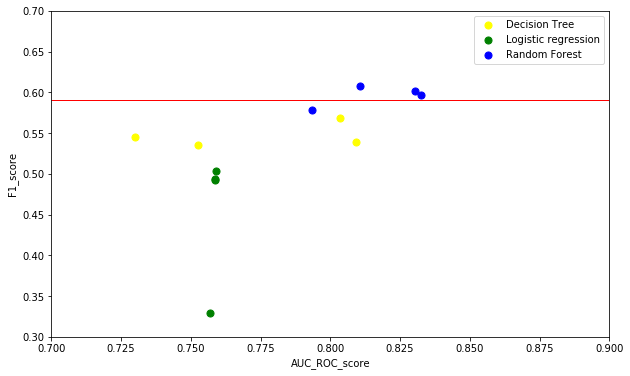

In [77]:
categories = np.unique(models_comparison['model_type'])

plt.figure(figsize=(10, 6))
colors = ['yellow', 'green', 'blue']

for i, model_type in enumerate(categories):
    plt.scatter("auc_roc_score", "f1_score",
                data=models_comparison.loc[models_comparison.model_type==model_type, :],
                color = colors[i], s = 50)
    
plt.gca().set(xlim=(0.7, 0.9), ylim=(0.3, 0.7), xlabel='AUC_ROC_score', ylabel='F1_score')
plt.legend(('Decision Tree', 'Logistic regression', 'Random Forest'))
plt.hlines(0.59, 0.7, 0.9, color="red", linewidth=1)

1. Исходя из результатов, полученных на валидационной выборке, заданному условию соответствует модели типа "случайный лес". Модели других типов "не дотягивают" по значению F1-меры, несмотря на относительно близкие значения AUC-ROC.
2. Балансировка классов практически не влияет на показатель AUC-ROC модели логистической регрессии. При этом прирост показателя F1-меры существенен по сравнению с "несбалансированными" обучающими данными и практически не зависит от способам балансировки.
3. Напротив, балансировка классов модели случайного дерева сопровождается изменением показателя AUC-ROC как в меньшую (class-weight), так и большую сторону (UP- и DOWN-) по сравнению с "несбалансированным набором). Прирост значений F1-меры при это также присутствует, однако, он существенно меньше разницы, полученной для лог.рег. Также налицо "высокий" разброс полученных значений в зависимости от способа балансировки.
4. Для модели типа "случайный лес" получены наибольшие сочетаний значений F1-меры и AUC-ROC. Вне зависимости от типа балансировки, она сопровождается приростом обоих показателей качества модели. Вероятно, преимущества использования данной модели отчасти компенсируются МНОГО большим временем обучения, а также риском переобучения. 
5. Так или иначе, "жизнеспособность" разработанных моделей будет проверена на тестовой выборке данных.


# 4. Тестирование модели

Для тестирования моделей у нас давным-давно лежит тестовый набор данных на 1500 объектов.
Добавим в таблицу 2 столбца - "F1_score_test" и "auc_roc_score_test". 
Найдем "тестовые" значения показателей качества для тестовых данных и внесем их в сводную таблицу.

In [78]:
models_comparison["f1_score_test"] = ""
models_comparison["auc_roc_score_test"] = ""
models_list_test

['model_logreg',
 'model_dectree_best',
 'model_rndforest_best',
 'model_logreg_balanced',
 'model_dectree_balanced_best',
 'model_rndforest_balanced_best',
 'model_logreg_downsampled',
 'model_dectree_downsampled_best',
 'model_rndforest_downsampled_best',
 'model_logreg_upsampled',
 'model_dectree_upsampled_best',
 'model_rndforest_upsampled_best']

Сделаем функцию, для внесения данных в таблицу. Перечень моделей, которые мы будем тестировать мы собирали параллельно с заполнение таблицы в отдельный список "models_list_test"

In [79]:
def table_filler_test(model_name, row_number):
    predicted_test = model_name.predict(features_test)
    f1_score_model_test = f1_score(target_test, predicted_test)
        
    probabilities_test = model_name.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]
    auc_roc_model_test = roc_auc_score(target_test, probabilities_one_test)
        
    models_comparison.loc[row_number, "f1_score_test"] = f1_score_model_test
    models_comparison.loc[row_number, "auc_roc_score_test"] = auc_roc_model_test
    
    return models_comparison

table_filler_test(model_logreg, 0)
table_filler_test(model_dectree_best, 1)
table_filler_test(model_rndforest_best, 2)
table_filler_test(model_logreg_balanced, 3)
table_filler_test(model_dectree_balanced_best, 4)
table_filler_test(model_rndforest_balanced_best, 5)
table_filler_test(model_logreg_downsampled, 6)
table_filler_test(model_dectree_downsampled_best, 7)
table_filler_test(model_rndforest_downsampled_best, 8)
table_filler_test(model_logreg_upsampled, 9)
table_filler_test(model_dectree_upsampled_best, 10)
table_filler_test(model_rndforest_upsampled_best, 11)

,model_type,max_depth,n_estimators,balance_type,f1_score,auc_roc_score,f1_score_test,auc_roc_score_test
0,Logistic regression,-,-,-,0.329670,0.756852,0.267352,0.758294
1,Decision Tree,10,-,-,0.535774,0.752397,0.537037,0.795462
2,Random Forest,25,15,-,0.578182,0.793588,0.566735,0.824064
3,Logistic regression,-,-,class_weight,0.493363,0.758790,0.489647,0.765686
4,Decision Tree,10,-,class_weight,0.545455,0.730038,0.548341,0.770015
5,Random Forest,7,17,class_weight,0.601078,0.830275,0.597285,0.85558
6,Logistic regression,-,-,Downsampling,0.503834,0.759156,0.480287,0.763
7,Decision Tree,6,-,Downsampling,0.568502,0.803579,0.539326,0.818743
8,Random Forest,9,28,Downsampling,0.596107,0.832392,0.580027,0.851971
9,Logistic regression,-,-,Upsampling,0.492274,0.758790,0.491525,0.765717


Изменения в показателях для тестовой и валидационной выборки налицо. Составим "итоговую таблицу", в которую включим все модели, соответствующие условиям задачи.

In [80]:
models_comparison[models_comparison['f1_score_test'] > 0.59]

,model_type,max_depth,n_estimators,balance_type,f1_score,auc_roc_score,f1_score_test,auc_roc_score_test
5,Random Forest,7,17,class_weight,0.601078,0.830275,0.597285,0.85558


Победитель - модель типа "случайный лес" и стандратной балансировкой "class_weight" - изменением веса классов.

Однако, поскольку мы здесь в первую очередь исследователи, посмотрим на то, как изменились значения показателей качества после тестирования.

### Сравнение валидационной и тестовой точности моделей

In [81]:
models_comparison_test = pd.DataFrame()
models_comparison_test['model_name_balance_type'] = (models_comparison['model_type'] 
                                                     + " (" + models_comparison['balance_type'] + ")")

models_comparison_test['f1_score'] = models_comparison['f1_score']
models_comparison_test['auc_roc_score'] = models_comparison['auc_roc_score']

models_comparison_test['f1_delta'] = models_comparison['f1_score_test'] - models_comparison['f1_score']
models_comparison_test['auc_roc_delta'] = models_comparison['auc_roc_score_test'] - models_comparison['auc_roc_score'] 

models_comparison_test

,model_name_balance_type,f1_score,auc_roc_score,f1_delta,auc_roc_delta
0,Logistic regression (-),0.329670,0.756852,-0.0623181,0.0014422
1,Decision Tree (-),0.535774,0.752397,0.00126333,0.0430654
2,Random Forest (-),0.578182,0.793588,-0.0114467,0.0304759
3,Logistic regression (class_weight),0.493363,0.758790,-0.00371606,0.00689546
4,Decision Tree (class_weight),0.545455,0.730038,0.002886,0.0399771
5,Random Forest (class_weight),0.601078,0.830275,-0.0037931,0.0253044
6,Logistic regression (Downsampling),0.503834,0.759156,-0.0235468,0.00384371
7,Decision Tree (Downsampling),0.568502,0.803579,-0.0291761,0.015164
8,Random Forest (Downsampling),0.596107,0.832392,-0.0160797,0.0195791
9,Logistic regression (Upsampling),0.492274,0.758790,-0.000748307,0.00692689


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

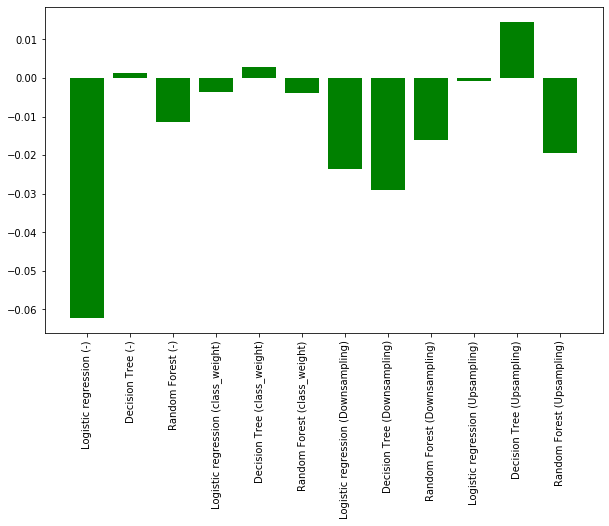

In [82]:
plt.figure(figsize=(10, 6))
plt.bar(models_comparison_test['model_name_balance_type'], models_comparison_test['f1_delta'],color = "green")
plt.xticks(rotation=90)

На тестовой выборке, практически повсеместно наблюдается падение показателя F1-меры. История с решающим деревом + АПсамплингом - скорее исключение, чем правило.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

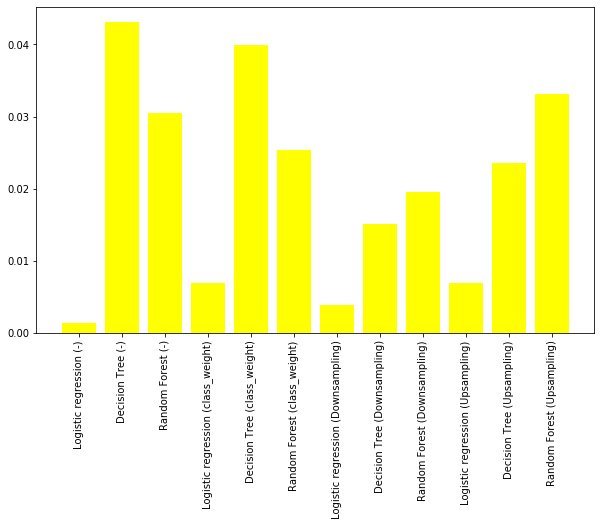

In [83]:
plt.figure(figsize=(10, 6))
plt.bar(models_comparison_test['model_name_balance_type'], models_comparison_test['auc_roc_delta'],color = "yellow")
plt.xticks(rotation=90)

Напротив, для показателя AUC-ROC наблюдается прирост во всех без исключения случаях.

## 5. Выводы

1. Наибольшее значение F1-меры (на тестовой выборке) получено для модели "случайного леса" из 17 "деревьев" глубиной 7 и балансировкой целевых признаков по весу. Этой модели также соответствует наибольшее значение AUC-ROC (на тестовой выборке).
2. В целом, наилучшие значения по показателям качества получены для моделей "случайного леса". Наихудшие - для моделей логистической регрессии. Это не значит, что модели лог.рег. "не работают". Просто в нашем случае они "не подошли". Наверняка, они могут использоваться для не менее эффективного решения других задач.
3. В большинстве случаев, балансировка классов позволяет повысить значения целевых показателей качества. Тем не менее, в ряде случаев (особенно при относительно небольшом объеме обучающих данных), некоторые способы (например, даунсамплинг) могут приводить к снижению рассматриваемых показателей.

In [84]:
models_comparison[models_comparison['f1_score_test'] > 0.59]

,model_type,max_depth,n_estimators,balance_type,f1_score,auc_roc_score,f1_score_test,auc_roc_score_test
5,Random Forest,7,17,class_weight,0.601078,0.830275,0.597285,0.85558
